In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [283]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [285]:
matplotlib.font_manager._rebuild()
matplotlib.rc('font', family='TH Sarabun New')
# Support Thai font
#https://stackoverflow.com/questions/51810908/custom-fonts-in-google-colaboratory-matplotlib-charts?fbclid=IwAR2CjyBiibwkTfIdjDjIBlmLfmQqjX3-e_65CxPW7KnVyPe8RiVzU2JHaKs
#wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf -P /usr/local/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf

In [3]:
!ls files

all_annotated.tsv  temp.txt


### Text extraction

The dataset is https://www.kaggle.com/rtatman/the-umass-global-english-on-twitter-dataset  



This dataset contains 10,502 tweets, randomly sampled from all publicly available geotagged Twitter messages, annotated for being in English, non-English, or having code switching, language ambiguity or having been automatically generated. It includes messages sent from 130 different countries.


In [4]:
data_df = pd.read_csv('files/all_annotated.tsv', sep="\t")

In [5]:
data_df.head()

,Tweet ID,Country,Date,Tweet,Definitely English,Ambiguous,Definitely Not English,Code-Switched,Ambiguous due to Named Entities,Automatically Generated Tweets
0,434215992731136000,TR,2014-02-14,Bugün bulusmami lazimdiii,0,0,1,0,0,0
1,285903159434563584,TR,2013-01-01,Volkan konak adami tribe sokar yemin ederim :D,0,0,1,0,0,0
2,285948076496142336,NL,2013-01-01,Bed,1,0,0,0,0,0
3,285965965118824448,US,2013-01-01,I felt my first flash of violence at some fool...,1,0,0,0,0,0
4,286057979831275520,US,2013-01-01,Ladies drink and get in free till 10:30,1,0,0,0,0,0


### Determining the language

In [6]:
import langid 

LangID is a standalone Language Identification (LangID) tool. (https://github.com/saffsd/langid.py)

Lui, Marco and Timothy Baldwin (2011) Cross-domain Feature Selection for Language Identification, In Proceedings of the Fifth International Joint Conference on Natural Language Processing (IJCNLP 2011), Chiang Mai, Thailand, pp. 553—561. Available from http://www.aclweb.org/anthology/I11-1062

In [7]:
guessed_langs = data_df['Tweet'].apply(langid.classify)
langs = guessed_langs.apply(lambda tuple: tuple[0])
langs[:5]

0    az
1    ms
2    en
3    en
4    en
Name: Tweet, dtype: object

In [8]:
guess_en_labels = langs.apply(lambda x: 1 if x == 'en' else 0)
guess_en_labels = guess_en_labels.values

en_labels = data_df['Definitely English'].values

In [9]:
from sklearn.metrics import accuracy_score
y_pred = guess_en_labels
y_true = en_labels
print("Accuracy of guessed language using langid is {0}".format(accuracy_score(y_true, y_pred)))

Accuracy of guessed language using langid is 0.8268901161683488


In [10]:
print("Number of unique languages:")
print(len(langs.unique()))
print("")

print("Number of data in English:")
print(sum(langs=="en"))
print("")

print("Percent of data in English:")
print((sum(langs=="en")/len(langs))*100)
print("")

print("Number of data in Thai:")
print((sum(langs=="th")))
print("")

print("Percent of data in Thai:")
print((sum(langs=="th")/len(langs))*100)

Number of unique languages:
95

Number of data in English:
4302

Percent of data in English:
40.96362597600457

Number of data in Thai:
147

Percent of data in Thai:
1.399733384117311


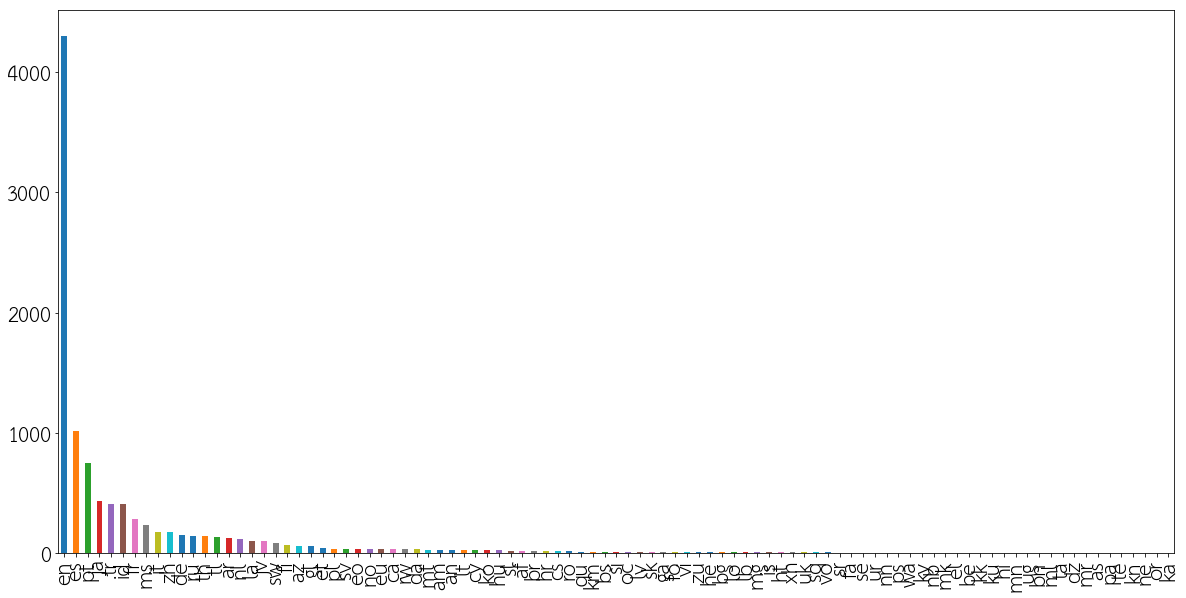

In [288]:
langs_df = pd.DataFrame(langs)
langs_count = langs_df.Tweet.value_counts()
langs_count.plot.bar(figsize=(20,10), fontsize=20)

Start from this step, we will work only with Thai text.

In [12]:
data_df['guessed_lang'] = langs

In [13]:
data_th_df = data_df[data_df["guessed_lang"] == 'th']

In [14]:
data_th_df["guessed_lang"].unique()

array(['th'], dtype=object)

In [15]:
data_th_df.head()

,Tweet ID,Country,Date,Tweet,Definitely English,Ambiguous,Definitely Not English,Code-Switched,Ambiguous due to Named Entities,Automatically Generated Tweets,guessed_lang
3583,450155396590993408,TH,2014-03-30,พี่มิวววววเกร้ด,0,0,1,0,0,0,th
3607,451223589384388608,TH,2014-04-02,En France. @ งานสัปดาห์หนังสือแห่งชาติครั้งที่...,0,1,0,1,0,0,th
3610,451347288049188864,TH,2014-04-02,หวังว่าคงไม่ใช่นะ,0,0,1,0,0,0,th
3715,456422077029826560,TH,2014-04-16,15 เมษา 1912 (102ปีที่เเล้ว) เรือไททานิกอับปาง...,0,0,1,0,0,0,th
3717,456441928729362432,TH,2014-04-16,@Santa_Xiuminbot มุ้งมิ้งอะไรรร~,0,0,1,0,0,0,th


In [16]:
print("There are {0} row left".format(len(data_th_df)))

There are 147 row left


### Part of speech tagging & Remove irrelevant words¶

In [247]:
import re
def clean_string(text):
    #https://stackoverflow.com/questions/38615740/regular-expression-to-accept-all-thai-characters-and-english-letters-in-python
    pattern = re.compile(r"[^\u0E00-\u0E7Fa-zA-Z' ]|^'|'$|''")
    char_to_remove = re.findall(pattern, text)
    list_with_char_removed = [char for char in text if not char in char_to_remove]
    text = ''.join(list_with_char_removed)
    
    #custom
    text = re.sub(r" https ", " http ", text)  
    text = re.sub(r'(.)\1{2,}', r'\1', text) # buuuuuttttt -> but
    return text

In [248]:
from pythainlp.corpus import stopwords 
from pythainlp.tokenize import word_tokenize # apt install libicu-dev # pip install pyicu
from pythainlp.tag import pos_tag

In [249]:
def th_tokenizer(text):
    tokens = word_tokenize(text=text, engine='icu')
    return tokens

In [256]:
def extract_th_noun_token(doc):
    word_w_pos = pos_tag(th_tokenizer(doc), engine='perceptron', corpus='orchid')
    noun_tokens = []
    for token, pos_item in word_w_pos:
        if pos_item in ["NPRP", "NCMN", "NTTL"] and len(token.strip()) > 1: 
            #https://www.researchgate.net/publication/243783378_Thai_Part-of-speech_Tagged_Corpus_ORCHID
            noun_tokens.append(token)
    return noun_tokens

In [257]:
data_th_df.loc[:,'Tweet_clean'] = data_th_df["Tweet"].apply(clean_string)

In [258]:
data_th_df.loc[:,'Tweet_noun_clean'] = data_th_df['Tweet_clean'].apply(extract_th_noun_token)

In [259]:
data_th_df.loc[:,'Tweet_noun_clean'] = data_th_df['Tweet_noun_clean'].apply(lambda x: " ".join(x) \
                                                                            if len(x) > 0 else "")

In [260]:
noun_tokens = []
for item in data_th_df['Tweet_noun_clean']:
    if item != '':
        noun_tokens += item.split()
print("There are {0} unique words detected as nouns".format(len(set(noun_tokens))))

There are 819 unique words detected as nouns


In [261]:
print("All of nouns tokens are: \n{0}".format(noun_tokens))

All of nouns tokens are: 
['พี่', 'เก', 'ร้ด', 'En', 'France', 'งาน', 'สัปดาห์', 'หนังสือ', 'ชาติ', 'ศูนย์', 'ชาติ', 'สิ', 'ริกิ', 'ตต์', 'httptcoyhheWpqd', 'นะ', 'เมษา', 'ปี', 'เรือ', 'ไท', 'ทา', 'นิ', 'กอับ', 'ปาง', 'เมษา', 'ตอน', 'เฟ', 'รี่', 'ล่ม', 'เเล้', 'วอีก', 'ปี', 'หน้า', 'nPrayForSouthKorea', 'SantaXiuminbot', 'มุ้ง', 'มิ้', 'งอะ', 'ไร', 'ฝน', 'at', 'CentralWorld', 'เซ็นทรัล', 'เวิลด์', 'others', 'httptcoHfvcYvXWu', 'KarNatthaporn', 'งาน', 'ไร', 'เอั', 'นะ', 'พรุ่ง', 'โซน', 'หน้า', 'คอม', 'nLOSTPLANETinSEOUL', 'AnavilAFAL', 'แบบ', 'ฟลู', 'ค่า', 'ขนม', 'ผิช', 'ฝัน', 'คิดถึง', 'วาย', 'คิ', 'ถึ', 'httptcolxWxBYyRd', 'น่า', 'thelittlemermaid', 'Ariel', 'linestickers', 'official', 'flounder', 'underthesea', 'httptcoJjnlRSKln', 'รุ้ง', 'ริ้ง', 'หนุ่ม', 'FSI', 'npetetosapol', 'ehipx', 'พี', 'เรื่อง', 'สติ้', 'เก้อ', 'ไลน์', 'สี่', 'httptcolTWOXhO', 'BelliiCAbePA', 'ปลาย', 'ปลาย', 'ตี', 'นครั', 'สติ', 'มาๆ', 'ไปๆ', 'ไร', 'ไร', 'รัช', 'jsradio', 'คิว', 'httptcovGIXee', 'chatchafern',

### Cluster documents into logical groups

#### Transform the cleaned text documents into numerical vectors
#### Reduce dimensionality
####  Apply Clustering algorithm
####  Visualizing the results

In [262]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [263]:
cleaned_texts = data_th_df['Tweet_noun_clean'].values

tfidf_vectorizer = TfidfVectorizer(
    min_df=1, max_features=None, strip_accents='unicode', lowercase=True,
    analyzer='word', ngram_range=(1, 1), use_idf=True, 
    smooth_idf=True, sublinear_tf=True, tokenizer=th_tokenizer, stop_words=stopwords.words('thai')
)
tfidf_vectorizer.fit(cleaned_texts)

/usr/local/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:286: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens [' ', ' \ufeff', 'กระ', 'กระไร', 'กาล', 'ก้อน', 'กํา', 'คน', 'คืน', 'คํา', 'งั้น', 'งาน', 'งี้', 'จํา', 'ชิ้น', 'ดี', 'ด้อย', 'ตัว', 'ต้น', 'ถัด', 'ถ้วน', 'ทันใด', 'ท่าน', 'ท้าย', 'ทําให', 'ทําไม', 'ทําๆ', 'นา', 'นี้', 'บัด', 'ปวง', 'ปี', 'มวล', 'มั่น', 'มือ', 'ยะๆ', 'ระ', 'ลัง', 'ล่ะ', 'ล่าง', 'วาน', 'ศก', 'สมควร', 'สมบูรณ์', 'สืบ', 'สําคัญ', 'สําห', 'หนด', 'หน้า', 'หมาย', 'หา', 'อันว่า', 'อาทิ', 'เกี่ยว', 'เก่า', 'เคียง', 'เจียน', 'เฉก', 'เช้า', 'เดิม', 'เดี๋ยว', 'เติม', 'เต็ม', 'เนื่อง', 'เปล่า', 'เป็นไร', 'เผย', 'เย็น', 'เล่า', 'เวลา', 'เสมือน', 'เหนือ', 'เหมาะ', 'เหมือน', 'แด่', 'แน่ะ', 'แม้น', 'แหล่', 'โง้น', 'โน้น', 'ใด', 'ไว', 'ไหม', 'ไหร่'] not in stop_words.
  sorted(inconsistent))


TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=['\ufeffนี้', 'นํา', 'นั้น', 'นัก', 'นอกจาก', 'ทุก', 'ที่สุด', 'ที่', 'ทําให้', 'ทํา', 'ทาง', 'ทั้งนี้', 'ดัง', 'ซึ่ง', 'ช่วง', 'จาก', 'จัด', 'จะ', 'คือ', 'ความ', 'ครั้ง', 'คง', 'ขึ้น', 'ของ', 'ขอ', 'รับ', 'ระหว่าง', 'รวม', 'ยัง', 'มี', 'มาก', 'มา', 'พร้อม', 'พบ', 'ผ่าน', 'ผล', 'บาง', 'น่...ันไหน', 'อันๆ', 'อาจจะ', 'อาจเป็น', 'อาจเป็นด้วย', 'อื่น', 'อื่นๆ', 'เอ็ง', 'เอา', 'ฯ', 'ฯล', 'ฯลฯ'],
        strip_accents='unicode', sublinear_tf=True,
        token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function th_tokenizer at 0x7f2d4b585ea0>, use_idf=True,
        vocabulary=None)

In [264]:
cleaned_texts_tfidf = tfidf_vectorizer.transform(cleaned_texts)

In [265]:
vocab_frame = pd.DataFrame({'words': list(tfidf_vectorizer.vocabulary_.keys())}, index = tfidf_vectorizer.vocabulary_.keys())
vocab_frame.head()

,words
พี่,พี่
,
เก,เก
ร้ด,ร้ด
en,en


In [266]:
print("Number of vocabulary of tfidf_vectorizer is {0} words".format(len(tfidf_vectorizer.vocabulary_)))

Number of vocabulary of tfidf_vectorizer is 800 words


#### k-means Clustering

In [267]:
from sklearn.cluster import KMeans

In [313]:
# number of clusters
n_clusters = 4

# fit k-mean clustering
kmeans = KMeans(n_clusters=n_clusters, random_state = 0)

kmeans.fit_predict(cleaned_texts_tfidf)

array([3, 1, 3, 1, 3, 2, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 1, 3,
       2, 3, 3, 3, 1, 3, 1, 3, 3, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 0, 3, 2, 3, 3, 3,
       0, 3, 2, 3, 0, 3, 3, 2, 2, 3, 1, 2, 2, 3, 2, 2, 1, 3, 3, 2, 3, 0,
       2, 3, 2, 2, 2, 2, 0, 3, 2, 3, 2, 2, 3, 3, 2, 3, 2, 2, 3, 2, 3, 2,
       2, 3, 0, 3, 0, 2, 2, 3, 3, 0, 3, 3, 3, 2, 2, 2, 2, 3, 3, 0, 3, 3,
       0, 3, 3, 2, 3, 2, 3, 3, 3, 3, 3, 2, 3, 3, 3], dtype=int32)

In [314]:
clusters = kmeans.labels_.tolist()
data_th_df.loc[:, 'clusters'] = clusters

/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [315]:
data_th_df['clusters'].value_counts() 

3    90
2    35
1    12
0    10
Name: clusters, dtype: int64

In [316]:
data_th_df.head()

,Tweet ID,Country,Date,Tweet,Definitely English,Ambiguous,Definitely Not English,Code-Switched,Ambiguous due to Named Entities,Automatically Generated Tweets,guessed_lang,Tweet_clean,Tweet_noun_clean,clusters
3,450155396590993408,TH,2014-03-30,พี่มิวววววเกร้ด,0,0,1,0,0,0,th,พี่มิวเกร้ด,พี่ เก ร้ด,3
1,451223589384388608,TH,2014-04-02,En France. @ งานสัปดาห์หนังสือแห่งชาติครั้งที่...,0,1,0,1,0,0,th,En France งานสัปดาห์หนังสือแห่งชาติครั้งที่ ศ...,En France งาน สัปดาห์ หนังสือ ชาติ ศูนย์ ชาติ ...,1
3,451347288049188864,TH,2014-04-02,หวังว่าคงไม่ใช่นะ,0,0,1,0,0,0,th,หวังว่าคงไม่ใช่นะ,นะ,3
1,456422077029826560,TH,2014-04-16,15 เมษา 1912 (102ปีที่เเล้ว) เรือไททานิกอับปาง...,0,0,1,0,0,0,th,เมษา ปีที่เเล้ว เรือไททานิกอับปางn เมษา ตอน...,เมษา ปี เรือ ไท ทา นิ กอับ ปาง เมษา ตอน เฟ รี่...,1
3,456441928729362432,TH,2014-04-16,@Santa_Xiuminbot มุ้งมิ้งอะไรรร~,0,0,1,0,0,0,th,SantaXiuminbot มุ้งมิ้งอะไร,SantaXiuminbot มุ้ง มิ้ งอะ ไร,3


In [317]:
data_th_df.index = data_th_df.clusters.values

In [318]:
print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1] 

for i in range(n_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :15]: # n words per cluster
        print(' %s' % vocab_frame.loc[tfidf_vectorizer.get_feature_names()[ind]].values.tolist()[0], end=',')
    print("\n")
    
    print("Cluster %d Country:" % i, end='')
    for country in data_th_df.loc[i]['Country'].unique():
        print(' %s,' % country, end='')
    print("\n")
    
    print("Cluster %d Automatically Generated Tweets:" % i, end='')
    for country in data_th_df.loc[i]['Automatically Generated Tweets'].unique():
        print(' %s,' % country, end='')
    print("\n")
    
    print("\n\n=========")
print("\n\n")

Top terms per cluster:

Cluster 0 words:  , chiang, กาแฟ, mai, mueang, in, พัก, rai, ratchaburi, darkgold, darkchocmocca, ฟิ, httpstcovxsdtyggb, khan, khiri,

Cluster 0 Country: TH,

Cluster 0 Automatically Generated Tweets: 0, 1,



Cluster 1 words:  , ปี, คน, งาน, เหงา, ใจ, ไม่รู้, เอั, karnatthaporn, ออ, เห้, แปป, ชาติ, กาด, infiniteeffect,

Cluster 1 Country: TH, CN,

Cluster 1 Automatically Generated Tweets: 0,



Cluster 2 words:  , at, i'm, in, bangkok, pathum, wan, bang, โรงเรียน, รา, samut, prakan, กอน, ratchathewi, siam,

Cluster 2 Country: TH,

Cluster 2 Automatically Generated Tweets: 0, 1,



Cluster 3 words:  , บ้าน, เอ้, สัส, เวลา, ไหร่, เดือน, โอกาส, เพลง, ค่า, tmyy, httptcoetjoovvti, งง, รี, ใจ,

Cluster 3 Country: TH, GB,

Cluster 3 Automatically Generated Tweets: 0, 1,








#### Multidimensional scaling

convert the dist matrix into a 2-dimensional array

In [319]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(cleaned_texts_tfidf)

In [320]:
from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
print("\n\n")

Visualizing document clusters

In [321]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a'}

#set up cluster names using a dict
cluster_names = {0: 'chiang, กาแฟ, mai, mueang, in, พัก', 
                 1: 'ปี, คน, งาน, เหงา, ใจ,', 
                 2: 'at, i\'m, in, bangkok, pathum, wan', 
                 3: ' บ้าน, เอ้, สัส, เวลา, ไหร่, เดือน'}

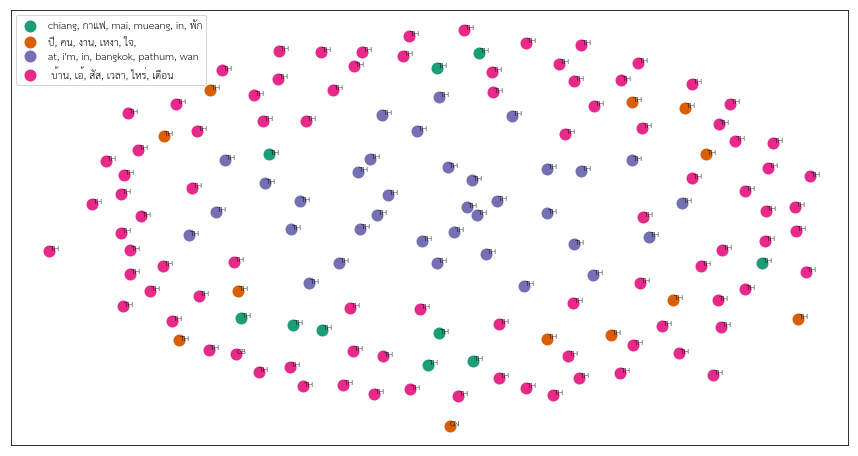

In [331]:
#create data frame that has the result of the MDS plus the cluster numbers and country
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, country=data_th_df['Country'].values)) 

#group by cluster
groups = df.groupby('label')

# set up plot
fig, ax = plt.subplots(figsize=(15, 8)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['country'], size=8)  

plt.savefig('files/clusters_thai.png', dpi=100)    
plt.show() #show the plot

### Summary

This dataset contains 10,502 tweets, randomly sampled from all publicly available geotagged Twitter messages. 

After cleaning the texts and filtering out unused words, the text messages are converted to Tf-idf vector then do clustering using k-means with number of cluster equal to 4.

According to the top terms per k-means cluster, 

There are 10 messages in Cluster 0 represent "Chiang Mai" and "Coffee"

There are 12 messages in Cluster 1 represent the concept of "lonely hearts"

There are 35 messages in Cluster 2 represent "Bangkok"

There are 90 messages in Cluster 3 represented with these words  บ้าน, เอ้, สัส, เวลา, ไหร่, เดือน, โอกาส, เพลง, ค่า
